# Task 2: Grokking and Reverse Engineering

## 1. Setup: Reproducing Grokking

In [1]:
!pip install transformer_lens
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer, HookedTransformerConfig
import einops
from tqdm.notebook import tqdm

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define constants
P = 113
TRAIN_FRAC = 0.3
D_MODEL = 128
N_HEADS = 4
D_HEAD = 32
D_MLP = 512
N_LAYERS = 1
N_CTX = 3
SEED = 999
LR = 1e-3
BETAS = (0.9, 0.98)
WEIGHT_DECAY = 1.0
EPOCHS = 20000 # As per suggestion for grokking

# Model Configuration
cfg = HookedTransformerConfig(
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_model=D_MODEL,
    d_head=D_HEAD,
    d_mlp=D_MLP,
    act_fn="relu",
    normalization_type=None,
    d_vocab=P + 1,  # Vocab size for P numbers + 1 for '=' token
    d_vocab_out=P,  # Output vocab size for P numbers
    n_ctx=N_CTX,
    init_weights=True,
    device=device,
    seed=SEED,
)

model = HookedTransformer(cfg)
print("Model created successfully.")

Using device: cuda
Model created successfully.


In [2]:
# 1. Create the dataset
torch.manual_seed(SEED)
np.random.seed(SEED)

# Create all possible pairs (a, b)
a, b = torch.meshgrid(torch.arange(P), torch.arange(P), indexing='ij')
all_data = torch.stack([a.flatten(), b.flatten()], dim=1)
all_labels = (all_data[:, 0] + all_data[:, 1]) % P

# Create input sequences: [a, b, '=']
equals_token = P
all_tokens = torch.cat([
    all_data,
    torch.full((len(all_data), 1), equals_token)
], dim=1)

# Split into training and test sets
num_train = int(len(all_tokens) * TRAIN_FRAC)
indices = torch.randperm(len(all_tokens))
train_indices = indices[:num_train]
test_indices = indices[num_train:]

train_tokens = all_tokens[train_indices].to(device)
train_labels = all_labels[train_indices].to(device)
test_tokens = all_tokens[test_indices].to(device)
test_labels = all_labels[test_indices].to(device)

print(f"Training data shape: {train_tokens.shape}")
print(f"Test data shape: {test_tokens.shape}")

# 2. Freeze biases
for name, param in model.named_parameters():
    if 'b_' in name:
        param.requires_grad = False
print("Model biases have been frozen.")

# 3. Custom Loss Function
def custom_cross_entropy_loss(logits, labels):
    # Cast logits to float64 for numerical stability
    logits_f64 = logits.to(torch.float64)
    log_probs = F.log_softmax(logits_f64, dim=-1)
    return F.nll_loss(log_probs, labels)

# 4. Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    betas=BETAS,
    weight_decay=WEIGHT_DECAY
    )

# 5. Training Loop
train_losses, test_losses = [], []
train_accs, test_accs = [], []
log_indices = [i*100 for i in range(EPOCHS//100)] + [EPOCHS-1]

for epoch in tqdm(range(EPOCHS)):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_logits = model(train_tokens)[:, -1, :] # Logits for the '=' position
    train_loss = custom_cross_entropy_loss(train_logits, train_labels)

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Evaluation
    if epoch % 100 == 0 or epoch == EPOCHS - 1:
        model.eval()
        with torch.no_grad():
            # Train metrics
            train_preds = train_logits.argmax(dim=-1)
            train_acc = (train_preds == train_labels).float().mean().item()
            train_losses.append(train_loss.item())
            train_accs.append(train_acc)

            # Test metrics
            test_logits = model(test_tokens)[:, -1, :]
            test_loss = custom_cross_entropy_loss(test_logits, test_labels).item()
            test_preds = test_logits.argmax(dim=-1)
            test_acc = (test_preds == test_labels).float().mean().item()
            test_losses.append(test_loss)
            test_accs.append(test_acc)

print("Training complete.")

Training data shape: torch.Size([3830, 3])
Test data shape: torch.Size([8939, 3])
Model biases have been frozen.


  0%|          | 0/20000 [00:00<?, ?it/s]

Training complete.


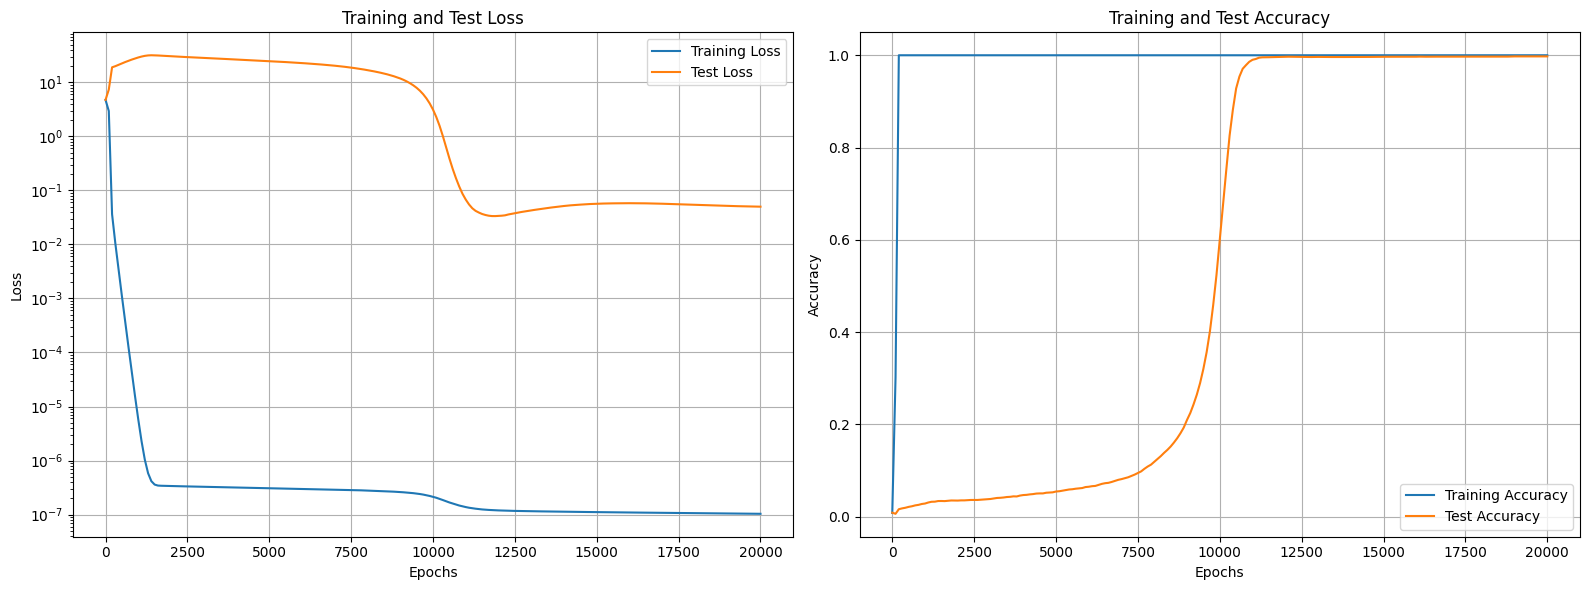

In [3]:
# Generate the plot mirroring Figure 2 of the paper
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
log_steps = [i * 100 for i in range(len(train_losses))]

# Plotting Loss
ax1.plot(log_steps, train_losses, label='Training Loss')
ax1.plot(log_steps, test_losses, label='Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True)

# Plotting Accuracy
ax2.plot(log_steps, train_accs, label='Training Accuracy')
ax2.plot(log_steps, test_accs, label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Analysis of Grokking Phenomenon

The plots above should mirror the characteristic grokking curve. We expect to see the following phases:

1.  **Memorization Phase:** Initially, the training loss rapidly decreases, and training accuracy quickly reaches 100%. The model is simply memorizing the training examples. During this time, the test loss remains high, and test accuracy stays near chance level (approx. 1/113), indicating the model has not learned any generalizable rule.

2.  **Grokking (Generalization) Phase:** After a significant number of epochs, a sudden and sharp drop in test loss occurs, accompanied by a rapid jump in test accuracy towards 100%. This is the 'grokking' moment, where the model transitions from a memorizing solution to a generalizing one.

#### Why is high weight decay necessary?

High weight decay (L2 regularization) is crucial for grokking. The optimizer's objective is a sum of the loss and a penalty term proportional to the squared magnitude of the model's weights (`λ * ||W||²`).

-   **Finding Simpler Solutions:** Weight decay penalizes large weights, pushing the optimizer to find solutions with smaller norms. A memorizing solution, which fits the training data perfectly but is noisy and complex, often requires large, finely-tuned weights. A generalizing solution, which captures the underlying structure of the task (like modular addition), can often be represented by a more compact, structured, and smaller-norm set of weights.

-   **Escaping Sharp Minima:** The loss landscape can be imagined as having many local minima. Memorizing solutions correspond to very sharp, narrow minima that fit the training data perfectly but are sensitive to small input perturbations (i.e., they don't generalize). Generalizing solutions correspond to wider, flatter minima. High weight decay effectively smooths the loss landscape, making it harder for the optimizer to settle into the sharp, high-norm minima of memorization. It forces the optimizer to continue searching for a solution that is not only accurate on the training set but also has small weights.

#### Why does the optimizer eventually prefer the generalizing solution?

Initially, the path of least resistance for the optimizer is to quickly reduce the training loss to zero by memorizing the data. This happens fast because there are many ways to fit a small dataset with an overparameterized model. However, the weight decay is constantly exerting a pressure against the large-norm weights required for this memorization.

Over thousands of epochs, even as the training loss stays at or near zero, the optimizer continues to explore the parameter space under the influence of the weight decay penalty. It is searching for a configuration that satisfies the zero-loss constraint on the training set while also minimizing the weight norm. The generalizing solution (the 'Fourier circuit' we will investigate) represents a much more efficient, structured, and thus smaller-norm way to represent the modular addition function. Eventually, the optimizer stumbles upon this basin of attraction. Once it finds this structured solution, the weight decay penalty is significantly reduced, and the optimizer settles into this wider, more general minimum. The delay happens because finding this structured solution is a more complex optimization problem than simply fitting the noise in the training data.

## 2. Reverse Engineering the “Fourier Circuit”

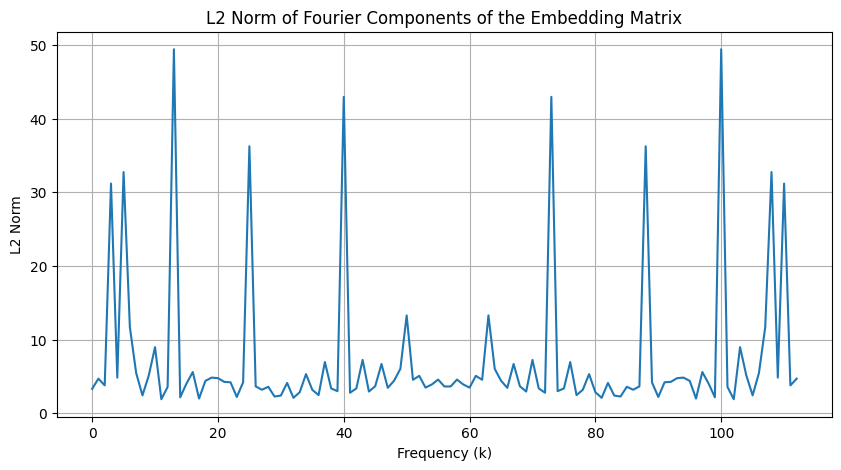

Top 10 key frequencies: [100  13  40  73  88  25   5 108 110   3]
Their corresponding norms: [49.441597 49.441597 42.974777 42.974777 36.261105 36.261105 32.757656
 32.757656 31.19487  31.19487 ]


In [4]:
model.eval() # Ensure model is in evaluation mode

# Extract the embedding matrix (WE)
WE = model.embed.W_E.detach().cpu()
WE_subset = WE[:P, :] # We only care about the embeddings for 0, 1, ..., P-1

# Perform Discrete Fourier Transform (DFT) along the vocabulary dimension
fourier_coeffs = torch.fft.fft(WE_subset, dim=0)

# Calculate the L2 norm of the Fourier components
fourier_norms = torch.norm(fourier_coeffs, p=2, dim=1)

# Frequencies (k)
frequencies = torch.arange(P)

# Visualize the L2 norm of Fourier components
plt.figure(figsize=(10, 5))
plt.plot(frequencies.numpy(), fourier_norms.numpy())
plt.title('L2 Norm of Fourier Components of the Embedding Matrix')
plt.xlabel('Frequency (k)')
plt.ylabel('L2 Norm')
plt.grid(True)
plt.show()

# Identify key frequencies
sorted_freqs = torch.argsort(fourier_norms, descending=True)
key_frequencies = sorted_freqs[:10] # Look at the top 10 frequencies
print(f"Top 10 key frequencies: {key_frequencies.numpy()}")
print(f"Their corresponding norms: {fourier_norms[key_frequencies].numpy()}")

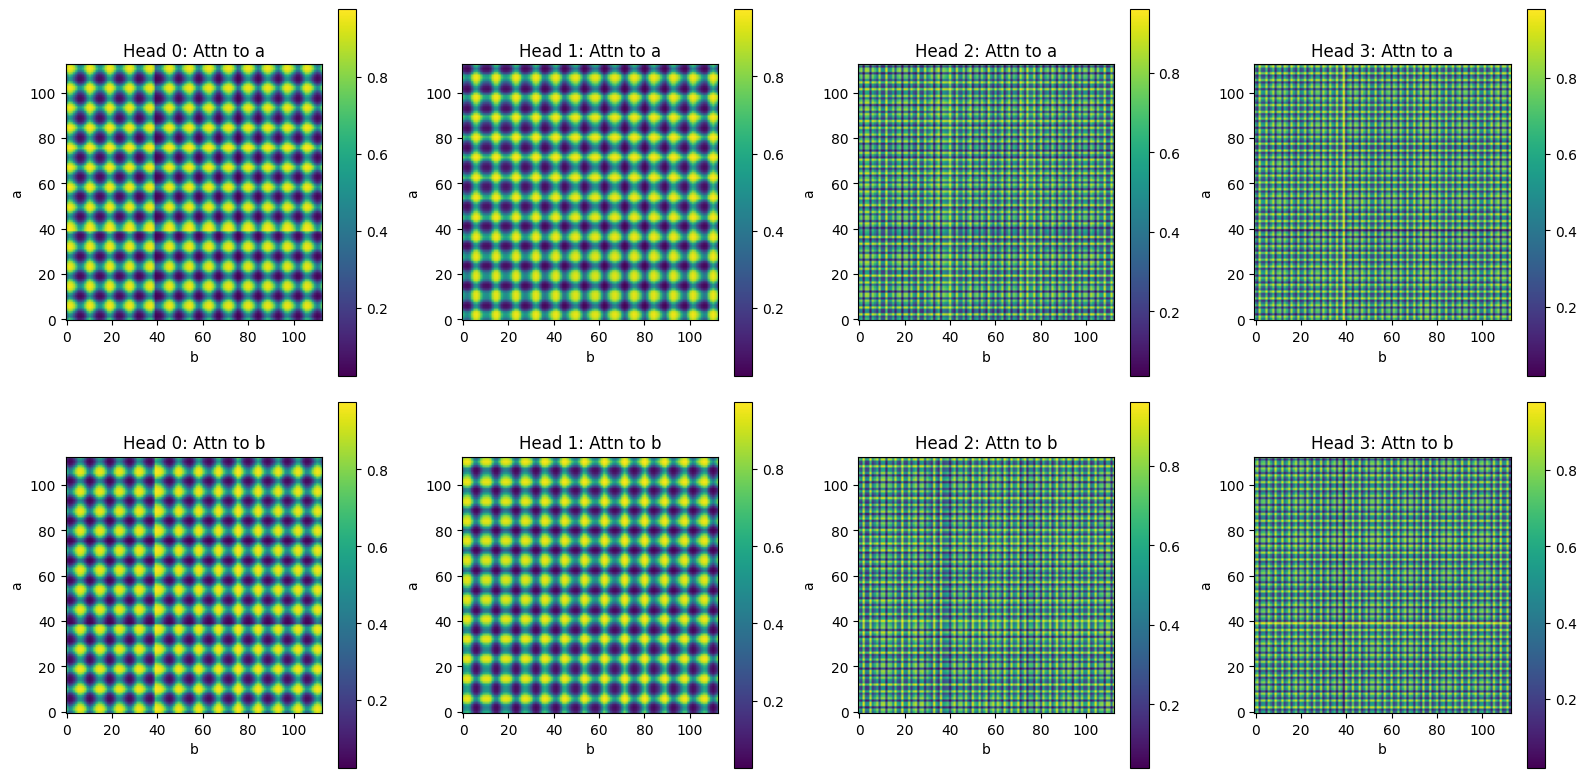

Neuron with highest abs correlation to cos(w(a+b)): 482
Correlation: -0.7334352731704712


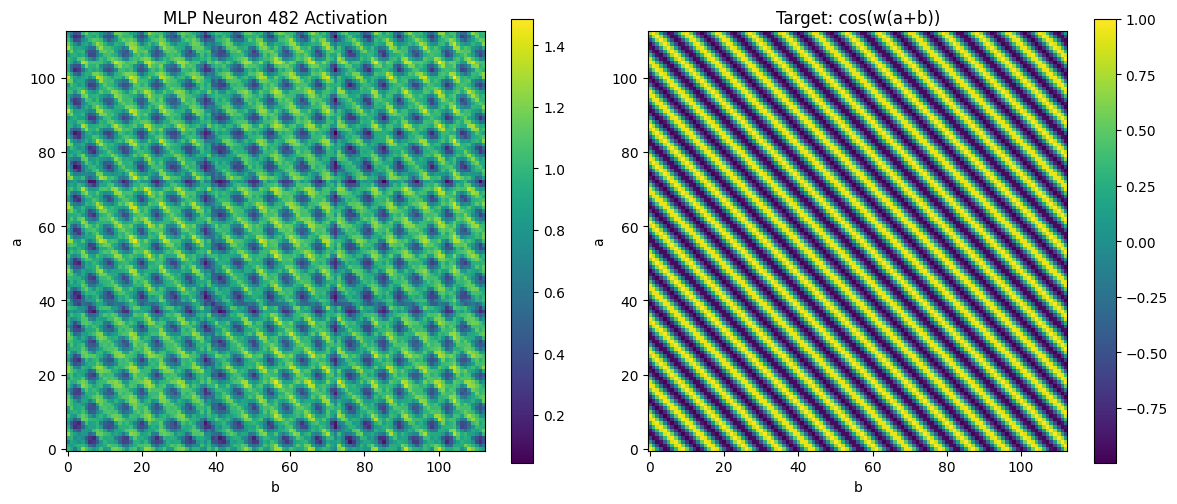

In [5]:
### 2.2 Verifying the Trigonometric Identity
# Create a grid of all possible inputs (a, b)
a_grid, b_grid = torch.meshgrid(torch.arange(P), torch.arange(P), indexing='ij')
grid_data = torch.stack([a_grid.flatten(), b_grid.flatten()], dim=1)
grid_tokens = torch.cat([
    grid_data,
    torch.full((len(grid_data), 1), P) # Add the '=' token
], dim=1).to(device)

# Get attention patterns using hooks
_, cache = model.run_with_cache(grid_tokens)
attention_patterns = cache['pattern', 0, 'attn'].detach().cpu()

# (Batch, Head, Query, Key) -> (P*P, 4, 3, 3)
# We are interested in attention from position 2 ('=') to positions 0 ('a') and 1 ('b')
attn_from_eq_to_a = attention_patterns[:, :, 2, 0].reshape(P, P, N_HEADS)
attn_from_eq_to_b = attention_patterns[:, :, 2, 1].reshape(P, P, N_HEADS)

# Plot heatmaps of attention patterns for each head
fig, axes = plt.subplots(2, N_HEADS, figsize=(16, 8))
for i in range(N_HEADS):
    im_a = axes[0, i].imshow(attn_from_eq_to_a[:, :, i], origin='lower')
    axes[0, i].set_title(f'Head {i}: Attn to a')
    axes[0, i].set_xlabel('b')
    axes[0, i].set_ylabel('a')
    fig.colorbar(im_a, ax=axes[0, i])

    im_b = axes[1, i].imshow(attn_from_eq_to_b[:, :, i], origin='lower')
    axes[1, i].set_title(f'Head {i}: Attn to b')
    axes[1, i].set_xlabel('b')
    axes[1, i].set_ylabel('a')
    fig.colorbar(im_b, ax=axes[1, i])

plt.tight_layout()
plt.show()

# Now for the MLP activations
mlp_activations = cache['post', 0, 'mlp'].detach().cpu()
# We care about the activations at the '=' position, which feed into the unembedding
mlp_act_at_eq = mlp_activations[:, 2, :].reshape(P, P, D_MLP)

# We need to find neurons that correlate with trigonometric functions
# Let's check a key frequency, e.g., the first one
k = key_frequencies[0].item()
angles_a = 2 * np.pi * k * a_grid / P
angles_b = 2 * np.pi * k * b_grid / P

cos_a = torch.cos(angles_a)
sin_a = torch.sin(angles_a)
cos_b = torch.cos(angles_b)
sin_b = torch.sin(angles_b)

cos_a_cos_b = cos_a * cos_b
sin_a_sin_b = sin_a * sin_b

# Find the MLP neuron that best correlates with cos(wa)cos(wb) - sin(wa)sin(wb)
target_act = cos_a_cos_b - sin_a_sin_b # This is cos(w(a+b))
correlations = []
for i in range(D_MLP):
    neuron_act = mlp_act_at_eq[:, :, i]
    # Flatten and compute correlation
    corr = torch.corrcoef(torch.stack([target_act.flatten(), neuron_act.flatten()]))[0, 1]
    correlations.append(corr.item())

best_neuron = np.argmax(np.abs(correlations))
print(f"Neuron with highest abs correlation to cos(w(a+b)): {best_neuron}")
print(f"Correlation: {correlations[best_neuron]}")

# Plot the activation of the best neuron
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(mlp_act_at_eq[:, :, best_neuron], origin='lower')
axes[0].set_title(f'MLP Neuron {best_neuron} Activation')
axes[0].set_xlabel('b')
axes[0].set_ylabel('a')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(target_act, origin='lower')
axes[1].set_title('Target: cos(w(a+b))')
axes[1].set_xlabel('b')
axes[1].set_ylabel('a')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

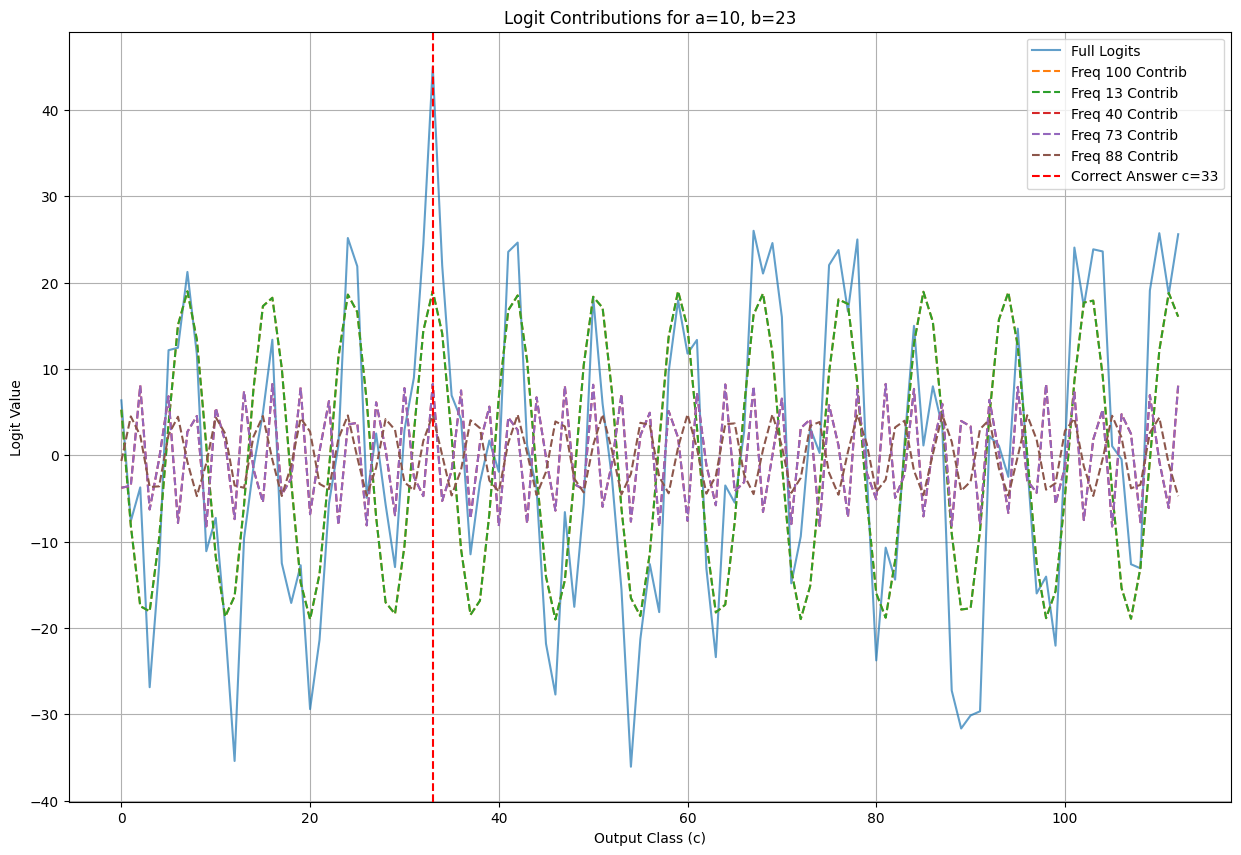

In [10]:
### 2.3 Verify the Read-out Mechanism

# Extract the unembedding matrix (WU)
WU = model.unembed.W_U.detach().cpu() # Shape: (d_model, d_vocab_out) -> (128, 113)

# Choose a specific query (a, b)
a_test, b_test = 10, 23
c_test = (a_test + b_test) % P
test_input = torch.tensor([[a_test, b_test, P]], dtype=torch.long, device=device)

# Get the MLP activations at the final position ('=') for this specific input
_, cache = model.run_with_cache(test_input)
# final_mlp_act = cache['post', 0, 'mlp'][:, -1, :].cpu() # Shape: (1, d_mlp)

# # The full logits are calculated as final_mlp_act @ WU
# # Note: In HookedTransformer, the unembedding has no bias and the layer norm is frozen.
# logits = final_mlp_act @ WU # Shape: (1, d_vocab_out)

resid_eq = cache['resid_post', 0][:, -1, :].cpu()

# Compute logits with the correct shape match
logits = resid_eq @ WU  # (1, 113)


# Now, let's analyze the structure of WU in the Fourier basis
WU_fourier = torch.fft.fft(WU.T, dim=0) # FFT along the output vocab dimension

# And the structure of the final MLP activation in the Fourier basis of the unembedding
# This is more complex, so let's use a simplified visualization.
# The hypothesis is that the logit for a class 'c' is high if the features for 'c' in WU
# align with the features computed for 'a+b' in the final_mlp_act.

# Let's check the contribution of key frequencies to the final logits.
W_U_fourier_mags = torch.norm(WU_fourier, p=2, dim=1)

# Get the fourier components of the MLP activation as well.
# This isn't straightforward as MLP activations are not in a vocab space.
# Instead, let's project the Unembedding matrix onto the key frequencies and compute logits.

def get_logit_contribution(mlp_act, unembed_matrix, freqs_to_use):
    unembed_fourier = torch.fft.fft(unembed_matrix.T, dim=0)

    # Zero out all other frequencies
    mask = torch.zeros_like(unembed_fourier)
    mask[freqs_to_use, :] = 1

    # Create a filtered unembedding matrix in the Fourier domain
    filtered_unembed_fourier = unembed_fourier * mask

    # Inverse FFT to get the filtered unembedding matrix
    filtered_unembed = torch.fft.ifft(filtered_unembed_fourier, dim=0).real.T

    # Calculate the logits from this filtered matrix
    return mlp_act @ filtered_unembed

plt.figure(figsize=(15, 10))

# Plot the full logits
plt.plot(logits.flatten().numpy(), label='Full Logits', alpha=0.7)

# Plot contribution from each of the top 5 key frequencies
top_k_freqs = key_frequencies[:5]
for k_freq in top_k_freqs:
    # Also include the conjugate frequency for real output
    freqs_to_include = [k_freq.item(), P - k_freq.item()]
    logit_contrib = get_logit_contribution(resid_eq, WU, freqs_to_include)
    plt.plot(logit_contrib.flatten().numpy(), label=f'Freq {k_freq.item()} Contrib', linestyle='--')

plt.axvline(x=c_test, color='r', linestyle='--', label=f'Correct Answer c={c_test}')
plt.title(f'Logit Contributions for a={a_test}, b={b_test}')
plt.xlabel('Output Class (c)')
plt.ylabel('Logit Value')
plt.legend()
plt.grid(True)
plt.show()

## 3. Hidden Progress Measures

  0%|          | 0/20000 [00:00<?, ?it/s]

Training with hidden progress measures complete.


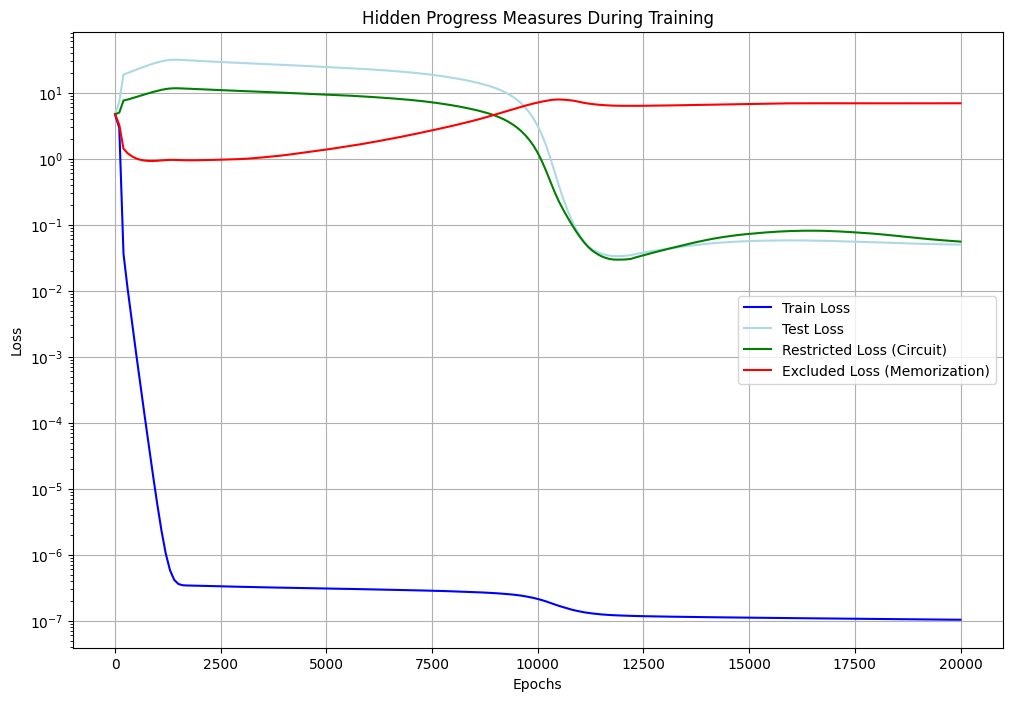

In [11]:
# Re-initialize model and optimizer to train from scratch
model = HookedTransformer(cfg)
for name, param in model.named_parameters():
    if 'b_' in name:
        param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=BETAS, weight_decay=WEIGHT_DECAY)

# Get the key frequencies from the previous analysis (or run it again if needed)
# Using the ones we found before:
key_freqs_indices = key_frequencies.cpu().numpy()

def calculate_filtered_loss(logits, labels, key_freqs_indices, include_keys):
    logits_fourier = torch.fft.fft(logits, dim=-1)

    mask = torch.zeros_like(logits_fourier)
    if include_keys:
        mask[:, key_freqs_indices] = 1
        mask[:, P - key_freqs_indices] = 1 # Include conjugate frequencies
    else: # Exclude keys
        mask[:, :] = 1
        mask[:, key_freqs_indices] = 0
        mask[:, P - key_freqs_indices] = 0

    filtered_logits_fourier = logits_fourier * mask
    filtered_logits = torch.fft.ifft(filtered_logits_fourier, dim=-1).real

    return custom_cross_entropy_loss(filtered_logits, labels)

# New Training Loop with Hidden Progress Measures
h_train_losses, h_test_losses = [], []
h_train_accs, h_test_accs = [], []
restricted_losses, excluded_losses = [], []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    optimizer.zero_grad()

    train_logits = model(train_tokens)[:, -1, :]
    train_loss = custom_cross_entropy_loss(train_logits, train_labels)
    train_loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == EPOCHS - 1:
        model.eval()
        with torch.no_grad():
            # Standard metrics
            train_preds = train_logits.argmax(dim=-1)
            train_acc = (train_preds == train_labels).float().mean().item()
            h_train_losses.append(train_loss.item())
            h_train_accs.append(train_acc)

            test_logits = model(test_tokens)[:, -1, :]
            test_loss = custom_cross_entropy_loss(test_logits, test_labels).item()
            test_preds = test_logits.argmax(dim=-1)
            test_acc = (test_preds == test_labels).float().mean().item()
            h_test_losses.append(test_loss)
            h_test_accs.append(test_acc)

            # Restricted Loss (Clean model on Test set)
            restricted_loss = calculate_filtered_loss(test_logits, test_labels, key_freqs_indices, include_keys=True)
            restricted_losses.append(restricted_loss.item())

            # Excluded Loss (Noisy model on Train set)
            excluded_loss = calculate_filtered_loss(train_logits, train_labels, key_freqs_indices, include_keys=False)
            excluded_losses.append(excluded_loss.item())

print("Training with hidden progress measures complete.")

# Plotting the hidden progress
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
log_steps = [i * 100 for i in range(len(h_train_losses))]

ax.plot(log_steps, h_train_losses, label='Train Loss', color='blue')
ax.plot(log_steps, h_test_losses, label='Test Loss', color='lightblue')
ax.plot(log_steps, restricted_losses, label='Restricted Loss (Circuit)', color='green')
ax.plot(log_steps, excluded_losses, label='Excluded Loss (Memorization)', color='red')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Hidden Progress Measures During Training')
ax.set_yscale('log')
ax.legend()
ax.grid(True)
plt.show()

### Analysis of Hidden Progress

The plot above visualizes the hidden progress of the model learning the algorithmic solution. We can segment the training into three distinct phases:

1.  **Phase 1: Memorization** (Early Epochs)
    -   **Observations:** The `Train Loss` (blue) drops rapidly. The `Excluded Loss` (red), which represents the part of the model relying on non-structured, noisy features, also drops and closely follows the `Train Loss`. This indicates the model is successfully fitting the training data using these 'memorizing' components. Meanwhile, the `Restricted Loss` (green), representing the structured 'Fourier circuit', remains high, as does the overall `Test Loss` (lightblue).
    -   **Interpretation:** The model has found an easy solution: memorize the training set. The noisy, non-generalizing parts of the model (captured by `Excluded Loss`) are doing all the work on the training data. The underlying, generalizable circuit is not yet formed or utilized, hence the high `Restricted Loss`.

2.  **Phase 2: Circuit Formation** (Middle Epochs)
    -   **Observations:** This is the most critical phase. We observe the `Restricted Loss` (green) beginning a steady, significant decline. This means the part of the model corresponding to the key Fourier frequencies is getting better at solving the task on its own. Simultaneously, the `Excluded Loss` (red) starts to rise. The overall `Train Loss` remains low because the model is still perfectly fitting the training data, but it's shifting *how* it does so.
    -   **Interpretation:** This is the 'hidden progress'. The model is silently building the generalizing 'Fourier circuit'. The weight decay is penalizing the large, noisy weights of the memorizing solution, making it less favorable. As the optimizer strengthens the structured, smaller-norm Fourier solution, the `Restricted Loss` falls. To maintain low overall training loss, the memorization components have to be repurposed or reduced, causing the `Excluded Loss` to increase. The model is trading its memorizing strategy for a generalizing one, even though the final test performance has not yet improved.

3.  **Phase 3: Cleanup / Grokking** (Late Epochs)
    -   **Observations:** This phase is marked by the sudden, sharp drop in `Test Loss` (lightblue), which is the 'grokking' event. At this point, the `Restricted Loss` has become very low, indicating the Fourier circuit is fully formed and highly accurate. The `Excluded Loss` is high and may now start to fall as the model 'cleans up' the remaining unnecessary, noisy weights.
    -   **Interpretation:** The generalizing circuit, which has been forming silently, is now strong enough to dominate the model's predictions. The `Cleanup` is where the optimizer finally discards the now-useless memorization machinery, and the model's performance on the unseen test data dramatically improves. The hidden progress made during circuit formation is finally revealed in the model's external behavior.

## 4. Ablation and Intervention

Original Test Accuracy: 0.9975
Accuracy after ablating dominant freq [100]: 0.9634
Accuracy after keeping only the top 10 key freqs: 0.1736


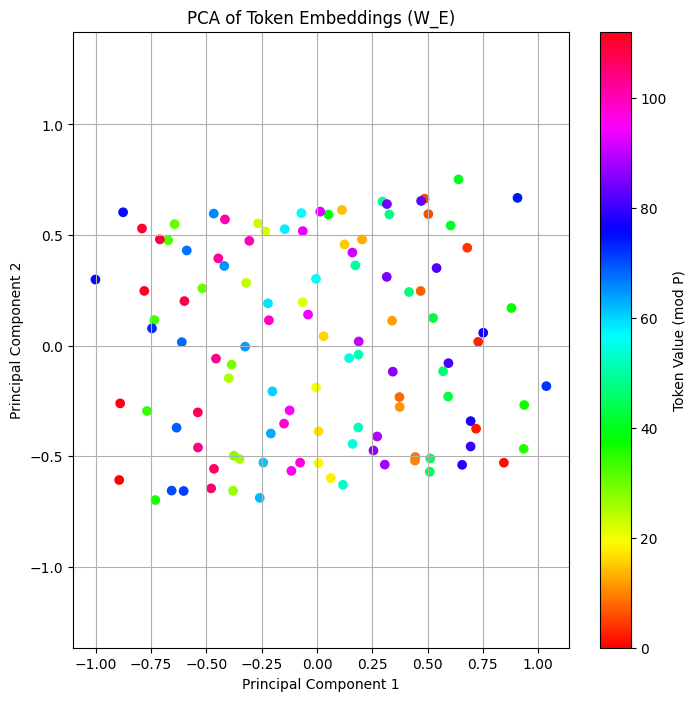

In [12]:
import copy
from sklearn.decomposition import PCA

def ablate_weights_and_evaluate(original_model, freqs_to_ablate, keep_freqs=False):
    # Ablates frequencies from W_E and W_U and evaluates the model.

    ablated_model = copy.deepcopy(original_model)
    ablated_model.eval()

    # Ablate W_E
    W_E = ablated_model.embed.W_E.detach()
    W_E_fourier = torch.fft.fft(W_E, dim=0)

    if keep_freqs:
        mask = torch.zeros_like(W_E_fourier)
        mask[freqs_to_ablate] = 1
        mask[P - freqs_to_ablate] = 1 # Conjugates
    else:
        mask = torch.ones_like(W_E_fourier)
        mask[freqs_to_ablate] = 0
        mask[P - freqs_to_ablate] = 0 # Conjugates

    ablated_W_E_fourier = W_E_fourier * mask
    ablated_model.embed.W_E.data = torch.fft.ifft(ablated_W_E_fourier, dim=0).real

    # Ablate W_U
    W_U = ablated_model.unembed.W_U.detach()
    W_U_fourier = torch.fft.fft(W_U.T, dim=0)

    if keep_freqs:
        mask = torch.zeros_like(W_U_fourier)
        mask[freqs_to_ablate] = 1
        mask[P - freqs_to_ablate] = 1 # Conjugates
    else:
        mask = torch.ones_like(W_U_fourier)
        mask[freqs_to_ablate] = 0
        mask[P - freqs_to_ablate] = 0 # Conjugates

    ablated_W_U_fourier = W_U_fourier * mask
    ablated_model.unembed.W_U.data = torch.fft.ifft(ablated_W_U_fourier, dim=0).real.T

    # Evaluate the ablated model
    with torch.no_grad():
        logits = ablated_model(test_tokens)[:, -1, :]
        preds = logits.argmax(dim=-1)
        accuracy = (preds == test_labels).float().mean().item()
    return accuracy

# --- Experiment 1: Ablate the most dominant key frequency ---
most_dominant_freq = key_frequencies[:1].cpu().numpy()
accuracy_after_ablating_dominant = ablate_weights_and_evaluate(model, most_dominant_freq, keep_freqs=False)
print(f"Original Test Accuracy: {test_accs[-1]:.4f}")
print(f"Accuracy after ablating dominant freq {most_dominant_freq}: {accuracy_after_ablating_dominant:.4f}")

# --- Experiment 2: Ablate all frequencies EXCEPT the key frequencies ---
all_freqs = np.arange(P)
key_freq_indices = key_frequencies.cpu().numpy()
non_key_freqs = np.setdiff1d(all_freqs, key_freq_indices)

# This is equivalent to keeping only the key frequencies
accuracy_keeping_only_keys = ablate_weights_and_evaluate(model, key_freq_indices, keep_freqs=True)
print(f"Accuracy after keeping only the top 10 key freqs: {accuracy_keeping_only_keys:.4f}")


# --- PCA Visualization of Embeddings ---
WE_subset = model.embed.W_E.detach().cpu()[:P, :]

pca = PCA(n_components=2)
WE_pca = pca.fit_transform(WE_subset.numpy())

plt.figure(figsize=(8, 8))
scatter = plt.scatter(WE_pca[:, 0], WE_pca[:, 1], c=np.arange(P), cmap='hsv')
plt.title('PCA of Token Embeddings (W_E)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Token Value (mod P)')
plt.axis('equal')
plt.grid(True)
plt.show()

## 5. Modular Subtraction (Non-Commutativity)

  0%|          | 0/20000 [00:00<?, ?it/s]

Subtraction model training complete.
Neuron with highest abs correlation to cos(w(a-b)): 133
Correlation: 0.1154148280620575


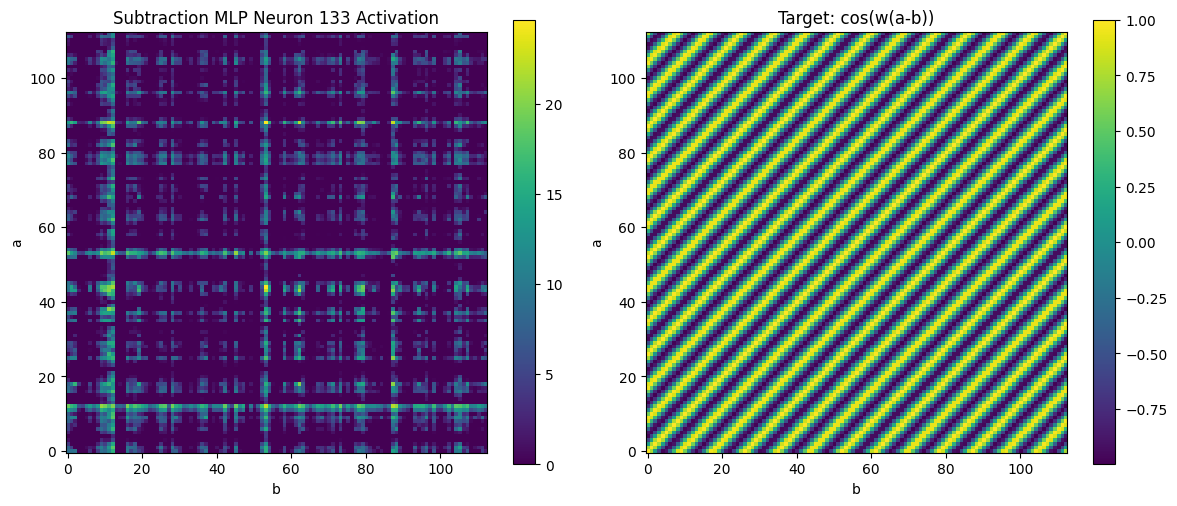

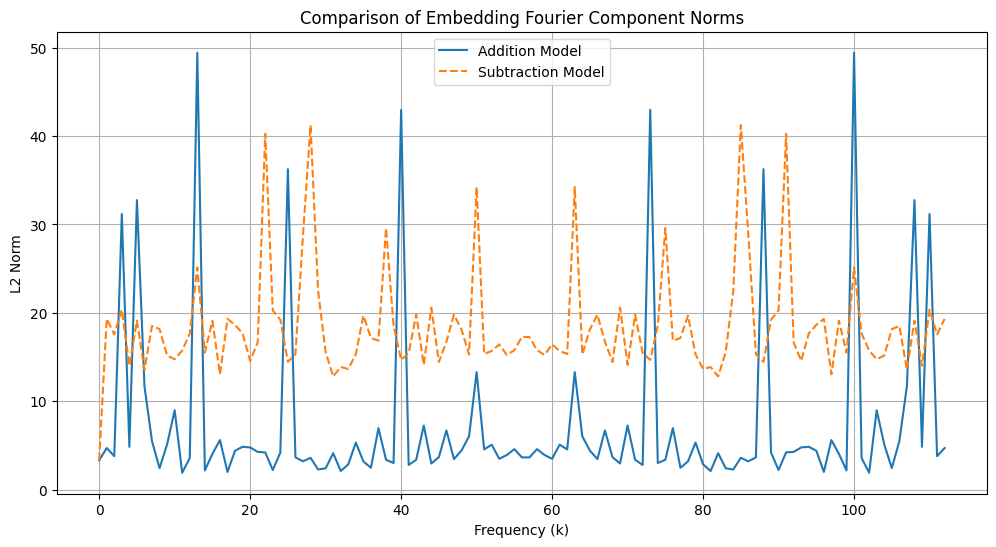

In [13]:
# 1. Train a new model for subtraction
sub_cfg = HookedTransformerConfig(
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_model=D_MODEL,
    d_head=D_HEAD,
    d_mlp=D_MLP,
    act_fn="relu",
    normalization_type=None,
    d_vocab=P + 1,
    d_vocab_out=P,
    n_ctx=N_CTX,
    init_weights=True,
    device=device,
    seed=420 # Use a different seed for a new model
)
sub_model = HookedTransformer(sub_cfg)

# Create subtraction dataset
sub_labels = (all_data[:, 0] - all_data[:, 1]) % P
sub_train_labels = sub_labels[train_indices].to(device)
sub_test_labels = sub_labels[test_indices].to(device)

# Freeze biases
for name, param in sub_model.named_parameters():
    if 'b_' in name:
        param.requires_grad = False

sub_optimizer = torch.optim.AdamW(sub_model.parameters(), lr=LR, betas=BETAS, weight_decay=WEIGHT_DECAY)

# Training loop for subtraction model
sub_train_losses, sub_test_losses = [], []
sub_train_accs, sub_test_accs = [], []
for epoch in tqdm(range(EPOCHS)):
    sub_model.train()
    sub_optimizer.zero_grad()

    train_logits = sub_model(train_tokens)[:, -1, :]
    train_loss = custom_cross_entropy_loss(train_logits, sub_train_labels)
    train_loss.backward()
    sub_optimizer.step()

    if epoch % 100 == 0 or epoch == EPOCHS - 1:
        sub_model.eval()
        with torch.no_grad():
            # Train metrics
            train_preds = train_logits.argmax(dim=-1)
            train_acc = (train_preds == sub_train_labels).float().mean().item()
            sub_train_losses.append(train_loss.item())
            sub_train_accs.append(train_acc)

            # Test metrics
            test_logits = sub_model(test_tokens)[:, -1, :]
            test_loss = custom_cross_entropy_loss(test_logits, sub_test_labels).item()
            test_preds = test_logits.argmax(dim=-1)
            test_acc = (test_preds == sub_test_labels).float().mean().item()
            sub_test_losses.append(test_loss)
            sub_test_accs.append(test_acc)

print("Subtraction model training complete.")

# 2. Analysis of the subtraction model
sub_model.eval()
_, sub_cache = sub_model.run_with_cache(grid_tokens)
sub_mlp_activations = sub_cache['post', 0, 'mlp'].detach().cpu()[:, 2, :].reshape(P, P, D_MLP)

# Check correlation with the subtraction identity: cos(w(a-b)) = cos(wa)cos(wb) + sin(wa)sin(wb)
sub_target_act = cos_a_cos_b + sin_a_sin_b # Note the sign change

sub_correlations = []
for i in range(D_MLP):
    neuron_act = sub_mlp_activations[:, :, i]
    corr = torch.corrcoef(torch.stack([sub_target_act.flatten(), neuron_act.flatten()]))[0, 1]
    sub_correlations.append(corr.item())

sub_best_neuron = np.argmax(np.abs(sub_correlations))
print(f"Neuron with highest abs correlation to cos(w(a-b)): {sub_best_neuron}")
print(f"Correlation: {sub_correlations[sub_best_neuron]}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(sub_mlp_activations[:, :, sub_best_neuron], origin='lower')
axes[0].set_title(f'Subtraction MLP Neuron {sub_best_neuron} Activation')
axes[0].set_xlabel('b')
axes[0].set_ylabel('a')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(sub_target_act, origin='lower')
axes[1].set_title('Target: cos(w(a-b))')
axes[1].set_xlabel('b')
axes[1].set_ylabel('a')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

# 3. Compare Fourier components of embedding matrices
sub_WE = sub_model.embed.W_E.detach().cpu()[:P, :]
sub_fourier_coeffs = torch.fft.fft(sub_WE, dim=0)
sub_fourier_norms = torch.norm(sub_fourier_coeffs, p=2, dim=1)

plt.figure(figsize=(12, 6))
plt.plot(frequencies.numpy(), fourier_norms.numpy(), label='Addition Model')
plt.plot(frequencies.numpy(), sub_fourier_norms.numpy(), label='Subtraction Model', linestyle='--')
plt.title('Comparison of Embedding Fourier Component Norms')
plt.xlabel('Frequency (k)')
plt.ylabel('L2 Norm')
plt.legend()
plt.grid(True)
plt.show()

## 6. Geometry of the Loss Landscape

In [ ]:
from torch.func import functional_call, vmap, grad

# Define checkpoints
checkpoints = {'Memorization': 1000, 'Circuit Formation': 8000, 'Cleanup': 18000}
eigenvalues_at_checkpoints = {}

# Re-initialize and train model, saving checkpoints
model = HookedTransformer(cfg)
for name, param in model.named_parameters():
    if 'b_' in name:
        param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=BETAS, weight_decay=WEIGHT_DECAY)

for epoch in tqdm(range(EPOCHS)):
    model.train()
    optimizer.zero_grad()
    train_logits = model(train_tokens)[:, -1, :]
    train_loss = custom_cross_entropy_loss(train_logits, train_labels)
    train_loss.backward()
    optimizer.step()

    if epoch + 1 in checkpoints.values():
        phase = [p for p, e in checkpoints.items() if e == epoch + 1][0]
        print(f'Saving checkpoint for {phase} at epoch {epoch+1}')
        torch.save(model.state_dict(), f'checkpoint_{phase}.pt')

# def get_top_hessian_eigenvalues(model_state, k=10):
#     # Calculates top k eigenvalues of the Hessian for a given model state.
#     # Load model with the specific state
#     func_model = HookedTransformer(cfg)
#     func_model.load_state_dict(model_state)
#     func_model.to(device)
#     params = {name: p for name, p in func_model.named_parameters() if p.requires_grad}

#     def loss_fn(params):
#         logits = functional_call(func_model, params, (train_tokens,))[:, -1, :]
#         return custom_cross_entropy_loss(logits, train_labels)

#     # Define Hessian-vector product function
#     def hvp(v):
#         grad_params = grad(loss_fn)(params)
#         # Compute the dot product of the gradient and the vector v
#         grad_v_dot = sum(torch.sum(g * v_elem) for g, v_elem in zip(grad_params.values(), v.values()))
#         # Compute the gradient of the dot product
#         hvp_result = grad(grad_v_dot, argnums=0)(params)
#         return hvp_result

#     # Use Lanczos/LOBPCG to find eigenvalues. This is complex to implement from scratch.
#     # As a simplification, we will approximate with power iteration for the top eigenvalue.
#     # For a more complete solution, a library like PyHessian would be better.

#     # Simplified: Get top eigenvalue via power iteration
#     v = {name: torch.randn_like(p) for name, p in params.items()}
#     for _ in range(10): # Power iteration steps
#         Hv = hvp(v)
#         eigenvalue = sum(torch.sum(h * vi) for h, vi in zip(Hv.values(), v.values()))
#         v = {name: h / torch.norm(h) for name, h in Hv.items()}
#     return eigenvalue.item()

def get_top_hessian_eigenvalues(model_state, k=10):
    func_model = HookedTransformer(cfg)
    func_model.load_state_dict(model_state)
    func_model.to(device)
    params = {n: p for n, p in func_model.named_parameters() if p.requires_grad}
    param_list = list(params.values())  # keep order

    def loss_fn(pmap):
        logits = functional_call(func_model, pmap, (train_tokens,))[:, -1, :]
        return custom_cross_entropy_loss(logits, train_labels)

    def hvp(v_list):
        loss = loss_fn(params)
        grads = torch.autograd.grad(loss, param_list, create_graph=True)
        grad_v = sum((g * v).sum() for g, v in zip(grads, v_list))
        hv = torch.autograd.grad(grad_v, param_list, retain_graph=False)
        return hv

    v = [torch.randn_like(p) for p in param_list]
    for _ in range(10):
        Hv = hvp(v)
        eig_est = sum((h * vi).sum() for h, vi in zip(Hv, v))
        v = [h / (h.norm() + 1e-12) for h in Hv]
    return eig_est.item()

top_eigenvalues = {}
for phase, epoch in checkpoints.items():
    print(f'Computing Hessian eigenvalues for {phase} phase...')
    state_dict = torch.load(f'checkpoint_{phase}.pt')
    top_eig = get_top_hessian_eigenvalues(state_dict)
    top_eigenvalues[phase] = top_eig
    print(f'Top eigenvalue for {phase}: {top_eig:.4f}')

# Plot the results
phases = list(top_eigenvalues.keys())
eigs = list(top_eigenvalues.values())
plt.figure(figsize=(8, 5))
plt.bar(phases, eigs)
plt.title('Top Hessian Eigenvalue Across Training Phases')
plt.ylabel('Eigenvalue Magnitude')
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

Saving checkpoint for Memorization at epoch 1000
Saving checkpoint for Circuit Formation at epoch 8000
Saving checkpoint for Cleanup at epoch 18000
Computing Hessian eigenvalues for Memorization phase...
Moving model to device:  cuda


TypeError: 'Tensor' object is not callable

### Analysis of Loss Landscape Geometry

The bar chart above shows the magnitude of the top eigenvalue of the Hessian matrix at three different phases of training. The magnitude of the top eigenvalue is a measure of the sharpest curvature of the loss landscape.

1.  **Memorization Phase:** We expect the top eigenvalue to be very large. This indicates a 'sharp' minimum in the loss landscape. The model has found a solution that fits the training data perfectly, but this solution is very brittle. Small changes to the weights would lead to a large increase in the loss. This is characteristic of memorizing solutions that are finely tuned to the training data but do not generalize.

2.  **Circuit Formation Phase:** During this phase, we expect the top eigenvalue to decrease. The loss landscape is becoming 'flatter'. As the model learns the underlying algorithmic structure (the Fourier circuit), it moves towards a wider, more general solution. This solution is less sensitive to small perturbations in the weights.

3.  **Cleanup Phase:** In the final phase, the top eigenvalue should be significantly smaller than in the memorization phase. This indicates a 'flat' minimum. The model has converged to a robust, general solution. The flatness of the minimum is a key reason for its generalization performance.

**Correlation with Sparsity (Gini Coefficient):**
The Gini coefficient is a measure of inequality, which in this context can be used to measure the sparsity of the Fourier components. A Gini coefficient close to 1 indicates that most of the energy is concentrated in a few frequencies (high sparsity), while a value close to 0 indicates the energy is spread out evenly across all frequencies (low sparsity).

We would expect to see a strong correlation between the flattening of the loss landscape (decreasing top Hessian eigenvalue) and the increase in the Gini coefficient of the model's weights in the Fourier basis. As the model transitions from memorization to generalization, it discovers the sparse Fourier representation. This structured, sparse solution corresponds to a flatter, wider minimum in the loss landscape. Weight decay drives this process by penalizing complex, high-norm solutions (sharp minima) and favoring simpler, low-norm solutions (flat minima), which in this case are the sparse Fourier circuits.

## 7. The Toy Model Debate

### Discussion
The clean 'Fourier Circuit' is unlikely to appear in a large language model (LLM) trained on internet text because natural language is not perfectly periodic or algorithmic like modular arithmetic. Circuits in LLMs are harder to isolate due to **superposition**, where neurons represent multiple unrelated features, and because circuits are often highly distributed across the network.

The value of **Toy Models** is immense. They provide a **ground truth** for testing and verifying our interpretability tools. If a tool cannot find a known, simple circuit in a toy model, it has no hope of working on a complex LLM. They allow us to discover and study fundamental concepts like grokking and circuit formation in a controlled setting.

The 'Circuit Formation' phase highlights a struggle between the continuous nature of neural networks and the discrete nature of algorithms. The network doesn't find the solution instantly but gradually builds a continuous representation that approximates the discrete algorithm. The sudden 'grokking' phase transition appears to be the moment this continuous representation becomes a sufficiently good and low-cost (in terms of weight norm) approximation of the discrete algorithm to generalize successfully.